In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.datasets import make_classification

from collections import defaultdict
from tqdm import tqdm

import math

In [91]:
n_samples = 1000
n_features = 2
n_classes = 2


X, y = datasets.make_blobs(n_samples= n_samples, n_features= n_features, centers= n_classes, cluster_std=[3, 2],random_state=2)
X.shape, y.shape

((1000, 2), (1000,))

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= y, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 2), (250, 2), (750,), (250,))

<AxesSubplot: >

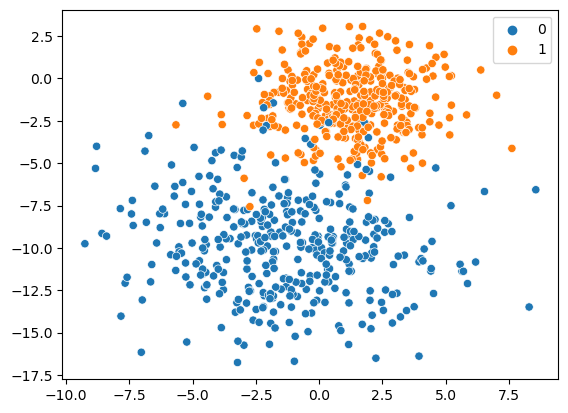

In [93]:
sns.scatterplot(x = X_train.T[0], y = X_train.T[1], hue = y_train)

In [94]:
class BayesModelClass:
    
    def __init__(self, data, target, method = "gnb") -> None:
        
        self.data = data
        self.target = target
        
        self.method = method
        
    def gaussian(self, X, mean, std):
        return np.exp((-(X - mean) **2)/std**2) / (2 * np.pi * std**2) ** 0.5

    def gaussian_fit(self, X):
        return np.mean(X, axis = 0), np.std(X, axis = 0)

    def gaussian_nb(self, X):
        y_pred = []
        for x_data in X:
            score = {}
            for group in self.classes:
                pdfs = self.pdf_data[group]
                
                mean_list = pdfs[0]
                std_list = pdfs[1]
                
                vfunc = np.vectorize(self.gaussian)    
                
                likelihood = np.prod(vfunc(x_data, mean_list, std_list))
                posterior  = likelihood * self.prior[group]
                
                score[group] = posterior
            y_pred.append(max(score, key=score.get))
        
        return np.array(y_pred)
    
    
    def unique_feature_counter(self, X):
        unique, counts = np.unique(X, return_counts=True)
        dictionary = defaultdict(int, zip(unique, counts))
        return dictionary
    
    def laplace_smoothened(self, cat, count_dict, constant):
        return (count_dict[cat] + constant)/(sum(count_dict.values()) + len(count_dict) * constant)
    
    def naive_bayes(self, X):
        y_pred = []
        for x_data in X:
            score = {}
            for group in self.classes:
                probs = self.prob_data[group]
                
                likelihood = 1
                iter_var = 0
                for x_i in x_data:
                    likelihood *= self.laplace_smoothened(x_i, probs[iter_var], self.laplace_constant)
                    iter_var +=1
                posterior  = likelihood * self.prior[group]
                score[group] = posterior
            y_pred.append(max(score, key=score.get))
        
        return np.array(y_pred)
    
    def predict(self, X):
        
        if self.method == "gnb":
            return self.gaussian_nb(X)
        
        if self.method == "nb":
            
            return self.naive_bayes(X)
        
    
    def evaluation_metrics(self, X = None, y = None, mode = "train", laplace_constant = 0):
        
        self.laplace_constant = laplace_constant
        if mode == "train":
            print("Training metrics")
            y_pred = self.predict(self.data)
            self.confusion_matrix(self.target, y_pred)
        
        elif (mode == 'test') and (X is not None) and (y is not None):
            print("Testing metrics")
            
            y_pred = self.predict(X)
            self.confusion_matrix(y, y_pred)
        

    def confusion_matrix(self, y, y_pred):
        
        a1_p1 = np.sum((y & y_pred))
        a1_p0 = y.sum() - a1_p1

        a0_p1 = y_pred.sum() - a1_p1
        a0_p0 = len(y) - y.sum() - a0_p1

        matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])

        plt.figure(figsize=(10,6))
        sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        
        ## Metrics
        Accuracy = (a1_p1 + a0_p0)/ len(y)
        Error_rate = 1 - Accuracy
        
        Sensitivity = a1_p1/y.sum()
        False_Negative_Rate = 1 - Sensitivity
        
        Specificity = a0_p0/(len(y) - y.sum())
        
        F1_score = 2 * Sensitivity * Specificity/(Sensitivity + Specificity)
        
        Precision = a1_p1/y_pred.sum()
        
        metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate", 
                                                "False Negative Rate", "Specificity/True Negative Rate", "F1 score",
                                                "Positive Predictive Value (PPV) or Precision"
                                               ],
                                   "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                                             Specificity, F1_score, Precision
                                             ]
        
        })
        metrics_df.set_index("Metrics", inplace = True)
        display(metrics_df)
   
    
    def fit(self):
        self.classes, counts = np.unique(self.target, return_counts=True)
        self.prior = counts/sum(counts)
        
        if self.method == "gnb":
            
            self.pdf_data = {}
            for group in self.classes:

                class_data = self.data[self.target == group]
                self.pdf_data[group] = np.apply_along_axis(self.gaussian_fit, 0, class_data)
        
        if self.method == "nb":
            
            self.prob_data = {}
            for group in self.classes:
                
                class_data = self.data[self.target == group]
                self.prob_data[group] = np.apply_along_axis(self.unique_feature_counter, 0, class_data)

In [95]:
model = BayesModelClass(data = X_train, target = y_train, method = "gnb")
model.fit()

In [96]:
model.pdf_data

{0: array([[-1.37570321, -9.75993436],
        [ 3.08458806,  2.96643245]]),
 1: array([[ 1.21732825, -1.37634718],
        [ 1.93183047,  1.88117367]])}

Training metrics


,Values
Metrics,
Accuracy,0.964000
Error rate,0.036000
Sensitivity/Recall/True Positive Rate,0.962667
False Negative Rate,0.037333
Specificity/True Negative Rate,0.965333
F1 score,0.963998
Positive Predictive Value (PPV) or Precision,0.965241


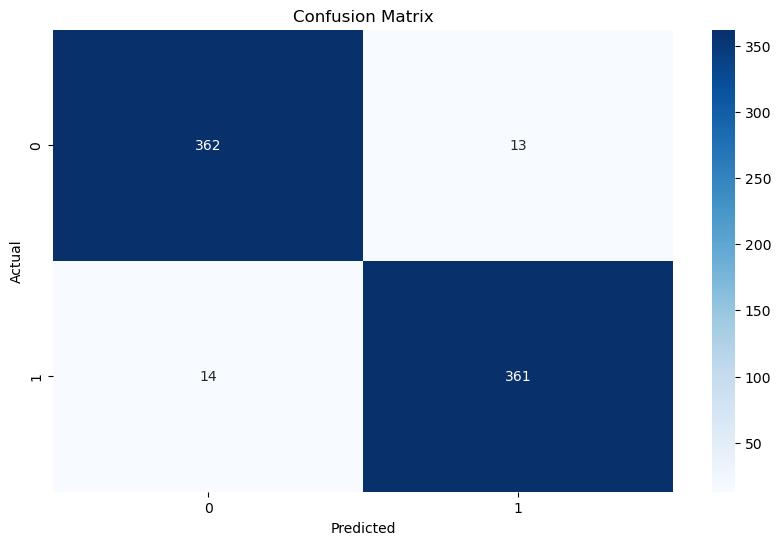

In [97]:
model.evaluation_metrics()

Testing metrics


,Values
Metrics,
Accuracy,0.952000
Error rate,0.048000
Sensitivity/Recall/True Positive Rate,0.936000
False Negative Rate,0.064000
Specificity/True Negative Rate,0.968000
F1 score,0.951731
Positive Predictive Value (PPV) or Precision,0.966942


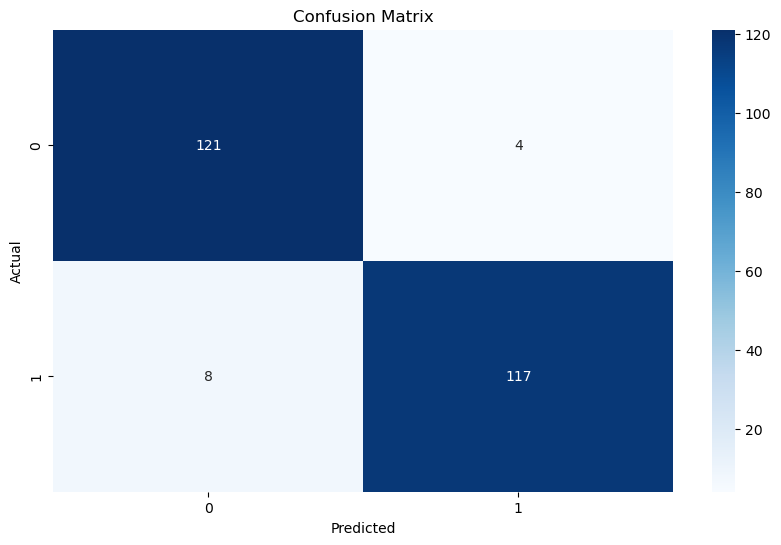

In [98]:
model.evaluation_metrics(X = X_test, y = y_test, mode = "test")

### Discrete

In [109]:
n_samples = 1000
n_features = 2
n_classes = 2
bin_limit = 1

# Generate a binary classification dataset with 2 informative features
X, y = make_classification(n_samples= n_samples, n_features= n_features, n_classes= n_classes, n_redundant = 0, random_state=42)

# Discretize the features
for i in range(X.shape[1]):
    bins = np.linspace(0, 1, bin_limit)
    X[:, i] = np.digitize(X[:, i], bins)

X[:10,:]

array([[0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.]])

In [110]:
y[:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= y, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 2), (250, 2), (750,), (250,))

In [112]:
%%time
model = BayesModelClass(data = X_train, target = y_train, method = "nb")
model.fit()

Wall time: 2.02 ms


In [113]:
model.prior

array([0.49733333, 0.50266667])

Training metrics


,Values
Metrics,
Accuracy,0.860000
Error rate,0.140000
Sensitivity/Recall/True Positive Rate,0.819629
False Negative Rate,0.180371
Specificity/True Negative Rate,0.900804
F1 score,0.858301
Positive Predictive Value (PPV) or Precision,0.893064


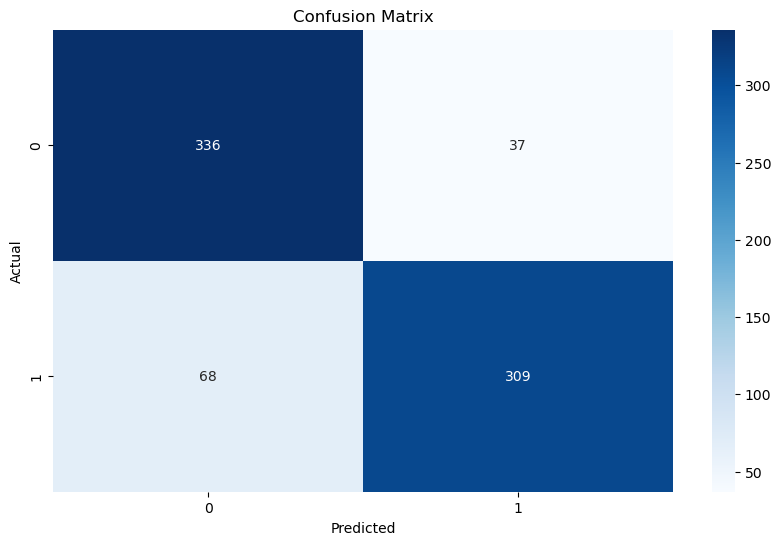

In [114]:
model.evaluation_metrics()

Testing metrics


,Values
Metrics,
Accuracy,0.876000
Error rate,0.124000
Sensitivity/Recall/True Positive Rate,0.832000
False Negative Rate,0.168000
Specificity/True Negative Rate,0.920000
F1 score,0.873790
Positive Predictive Value (PPV) or Precision,0.912281


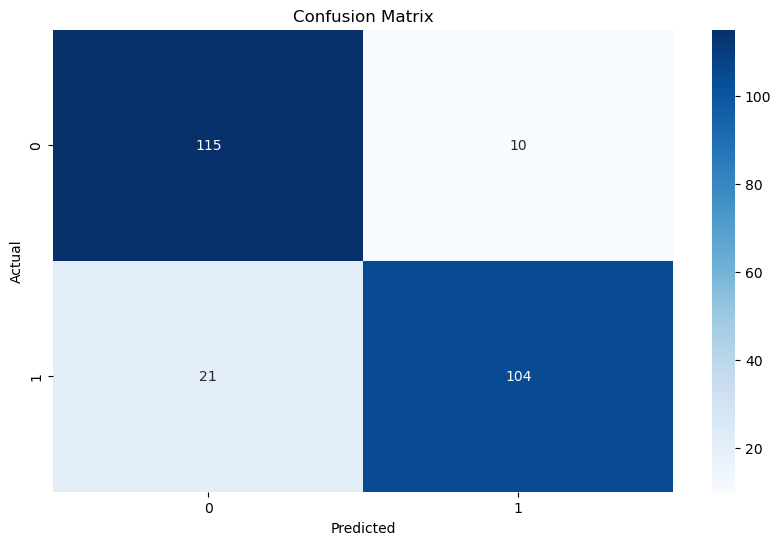

In [115]:
model.evaluation_metrics(X = X_test, y = y_test, mode = "test")

## With laplace constant

Training metrics


,Values
Metrics,
Accuracy,0.860000
Error rate,0.140000
Sensitivity/Recall/True Positive Rate,0.819629
False Negative Rate,0.180371
Specificity/True Negative Rate,0.900804
F1 score,0.858301
Positive Predictive Value (PPV) or Precision,0.893064


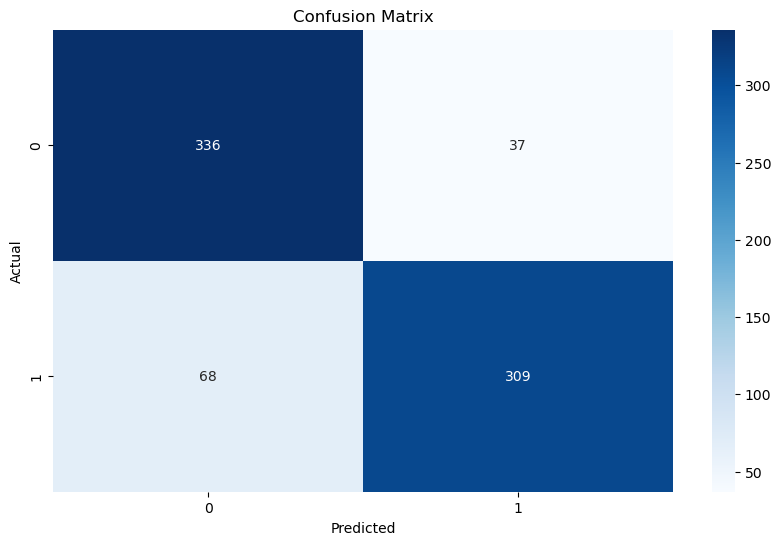

In [116]:
model.evaluation_metrics(laplace_constant = 10)

Testing metrics


,Values
Metrics,
Accuracy,0.876000
Error rate,0.124000
Sensitivity/Recall/True Positive Rate,0.832000
False Negative Rate,0.168000
Specificity/True Negative Rate,0.920000
F1 score,0.873790
Positive Predictive Value (PPV) or Precision,0.912281


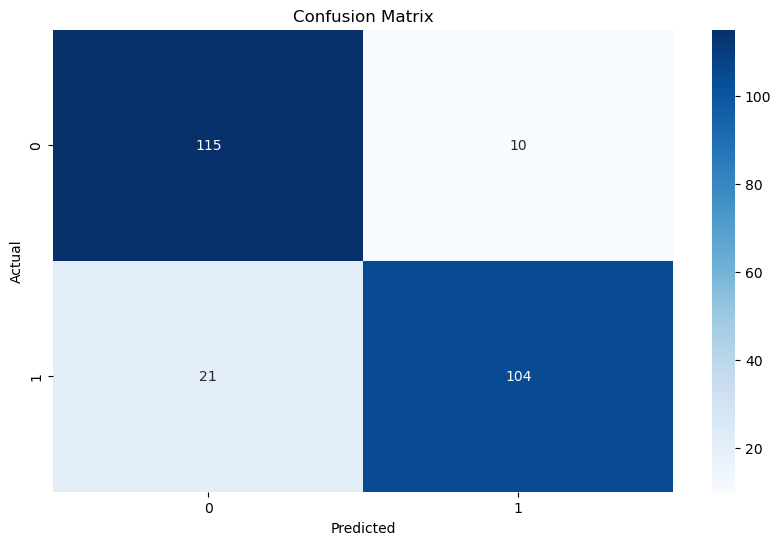

In [117]:
model.evaluation_metrics(X = X_test, y = y_test, mode = "test", laplace_constant = 10)